In [1]:
%matplotlib inline
import openpiv.tools
import openpiv.process
import openpiv.scaling
import pyov2sgd
import time

import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import *

In [2]:
# Read the pair of images
img_a  = openpiv.tools.imread( '/Users/Romain/Downloads/A/A001_1.tif' ).astype(np.int32)
img_b  = openpiv.tools.imread( '/Users/Romain/Downloads/A/A001_2.tif' ).astype(np.int32)

In [3]:
window_size = 32 # pixels
overlap = window_size // 2 # pixels, i.e. 50%
dt = 1. / 15 # 15 Hz laser and CCD recording
# process PIV
u, v, sig2noise = \
openpiv.process.extended_search_area_piv( \
                                         img_a, img_b, \
                                         window_size=window_size,\
                                         overlap = overlap, \
                                         dt = dt, \
                                         search_area_size= 2 * window_size, \
                                         sig2noise_method='peak2peak' )

# get the central points of the interrogation windows
x, y = openpiv.process.get_coordinates( image_size = img_a.shape, \
                                       window_size = window_size, \
                                       overlap  = overlap )

In [4]:
# peak to peak ratio to mask errorneous vectors is about 1.1 - 1.3
u, v, mask = openpiv.validation.sig2noise_val( u, v, sig2noise, threshold = 1.5 )

In [5]:
# Replace outliers (masked in the previous step) using the local mean filter:
# u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)

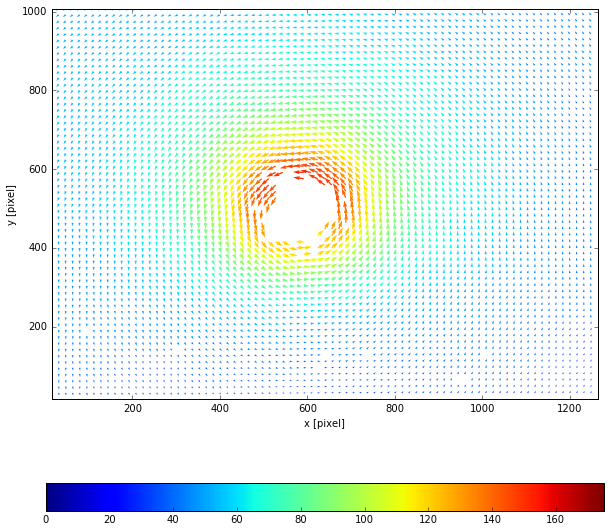

In [6]:
# Show the vectof flow field using vertical velocity for the color mapping
figure()
ax = axes()
quiver(x,y,u,v, (np.sqrt(u**2 + v**2)), clim=[0,175])
axis('tight')
ax.set_aspect(.9)
f = gcf()
f.set_size_inches(10,10)
colorbar(orientation='horizontal')
xlabel('x [pixel]')
ylabel('y [pixel]')

In [7]:
X = np.dstack((x, y)).reshape(-1, 2)
Y = np.dstack((u, v)).reshape(-1, 2)

Xt = X[~np.isnan(Y).any(axis=1), :].copy()
Yt = Y[~np.isnan(Y).any(axis=1), :].copy()

In [8]:
eta0 = 1.
lbda = 0.0
nu = 0.
block = 500
cond = 1e-10
cap = -1
T = 20
p = 2
batch = X.shape[0]

L = pyov2sgd.RidgeLoss()
B = pyov2sgd.DivergenceFreeGaussian(100., p)
# B = pyov2sgd.DecomposableSkewedChi2(np.eye(p), 20)
C = pyov2sgd.InverseScaling(eta0, 0, 0)

In [9]:
estimator = pyov2sgd.DivSOVK(L, B, C, p, lbda, nu, T, 
                             batch, block, cap, cond)
start = time.time()
estimator.fit_dense(Xt, Yt)
stop = time.time()
print(stop - start)
pred = estimator.predict_dense(X)
np.mean((pred - Y) ** 2)

77.99793004989624


nan

In [10]:
XP = X[:, 0].reshape((x.shape))
YP = X[:, 1].reshape((y.shape))
UP = pred[:, 0].reshape((u.shape))
VP = pred[:, 1].reshape((v.shape))

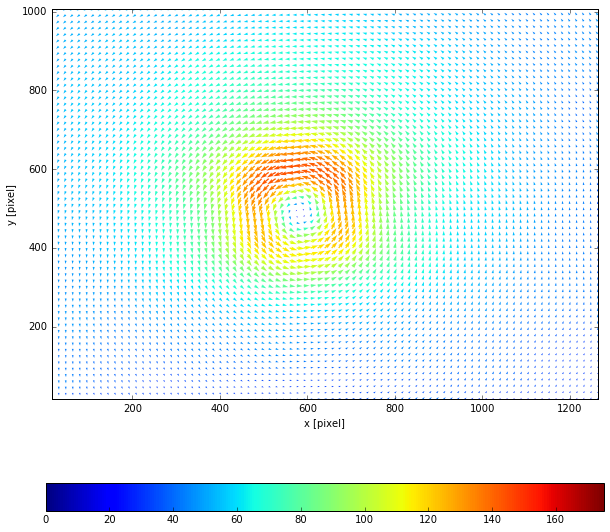

In [11]:
figure()
ax = axes()
quiver(XP, YP, UP, VP, np.sqrt(UP**2 + VP**2), clim=[0, 175])
axis('tight')
ax.set_aspect(.9)
f = gcf()
f.set_size_inches(10,10)
colorbar(orientation='horizontal')
xlabel('x [pixel]')
ylabel('y [pixel]')

In [12]:
eta0 = 1.
lbda = 0.0
nu = 0.
block = 500
cond = 1e-10
cap = -1
T = 20
p = 2
batch = X.shape[0]

L = pyov2sgd.RidgeLoss()
B = pyov2sgd.DecomposableGaussian(np.eye(p), 100.)
# B = pyov2sgd.DecomposableSkewedChi2(np.eye(p), 20)
C = pyov2sgd.InverseScaling(eta0, 0, 0)

In [13]:
estimator = pyov2sgd.DSOVK(L, B, C, p, lbda, nu, T, 
                           batch, block, cap, cond)
start = time.time()
estimator.fit_dense(Xt, Yt)
stop = time.time()
print(stop - start)
pred = estimator.predict_dense(X)
np.mean((pred - Y) ** 2)

200.14922094345093


nan

In [14]:
XP = X[:, 0].reshape((x.shape))
YP = X[:, 1].reshape((y.shape))
UP = pred[:, 0].reshape((u.shape))
VP = pred[:, 1].reshape((v.shape))

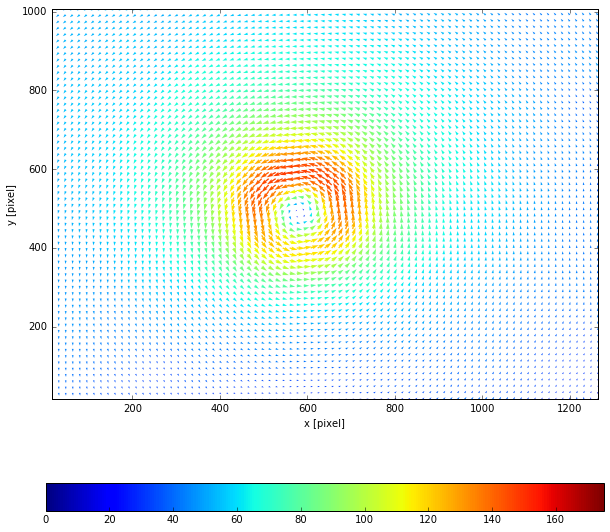

In [15]:
figure()
ax = axes()
quiver(XP, YP, UP, VP, np.sqrt(UP**2 + VP**2), clim=[0, 175])
axis('tight')
ax.set_aspect(.9)
f = gcf()
f.set_size_inches(10,10)
colorbar(orientation='horizontal')
xlabel('x [pixel]')
ylabel('y [pixel]')

In [90]:
# x2, y2 = x, y#np.meshgrid(np.arange(img_a.shape[0]), np.arange(img_a.shape[1]))
# X2 = X#np.dstack(np.meshgrid(np.arange(img_a.shape[0]), np.arange(img_a.shape[1]))).reshape(-1, 2)
x2 = np.meshgrid(np.arange(img_a.shape[0]), np.arange(img_a.shape[1]))[1].T
y2 = np.flipud(np.meshgrid(np.arange(img_a.shape[0]), np.arange(img_a.shape[1]))[0].T)
X2 = np.dstack((x2, y2)).reshape(-1, 2)
# # pred2 = X2
pred2 = estimator.predict_dense(X2)

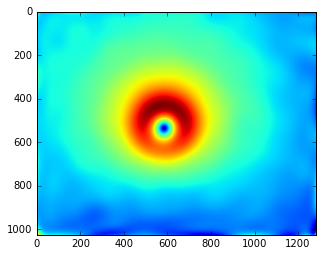

In [17]:
XP2 = X2[:, 0].reshape((x2.shape))
YP2 = X2[:, 1].reshape((x2.shape))
UP2 = pred2[:, 0].reshape((x2.shape))
VP2 = pred2[:, 1].reshape((x2.shape))
imshow(np.sqrt(UP2 ** 2 + VP2 ** 2))

In [19]:
from matplotlib.mlab import griddata
import scipy as sp

In [119]:
f = sp.interpolate.interp2d(np.arange(img_a.shape[1]), np.arange(img_a.shape[0]), img_a, kind='linear')

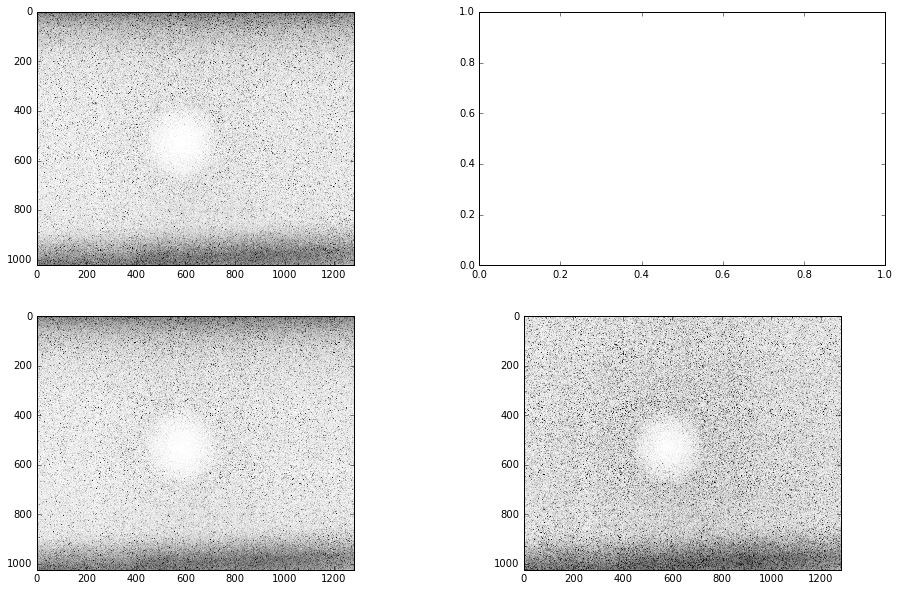

In [123]:
figure(figsize=(16, 10))
subplot(2, 2, 1)
imshow(f(np.arange(img_a.shape[0]), np.arange(img_a.shape[1])), cmap='Greys')

subplot(2, 2, 2)
# imshow(f((X[:, 0] + PP[:, 0]), (X[:, 1] + PP[:, 1])), cmap='Greys', extent=[0,img_b.shape[1],img_b.shape[0], 0])

subplot(2, 2, 3)
imshow(img_a, cmap='Greys')

subplot(2, 2, 4)
imshow(img_b, cmap='Greys')

In [99]:
f = sp.interpolate.interp2d(np.arange(img_a.shape[1]), np.arange(img_a.shape[0]), img_a, kind='linear')

array([[  -40.95274024,   969.4672068 ],
       [  -39.75293181,   971.6740124 ],
       [  -38.56826518,   973.77288613],
       ..., 
       [ 1234.51999109,   -48.15225899],
       [ 1234.735742  ,   -53.19284719],
       [ 1234.91607162,   -58.41984209]])

In [160]:
eta0 = 1.
lbda = 0.0
nu = 0.
block = 1
cond = 1e-10
cap = -1
T = 20
p = 1
batch = X2.shape[0]

L = pyov2sgd.RidgeLoss()
B = pyov2sgd.DecomposableGaussian(np.eye(p), 10.)
# B = pyov2sgd.DecomposableSkewedChi2(np.eye(p), 20)
C = pyov2sgd.InverseScaling(eta0, 0, 0)

In [161]:
estimator2 = pyov2sgd.DSOVK(L, B, C, p, lbda, nu, T, 
                           batch, block, cap, cond)
start = time.time()
estimator2.fit_dense(X2, img_a.reshape(-1, 1))
stop = time.time()
print(stop - start)
pred = estimator2.predict_dense(X2)
np.mean((pred - img_a.reshape(-1, 1)) ** 2)

69.58692598342896


6634.4977769875941

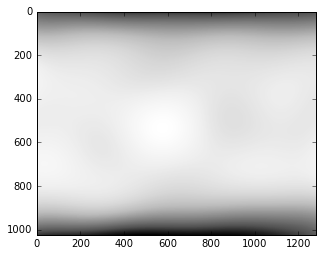

In [158]:
imshow(pred.reshape(img_a.shape), cmap='Greys')

In [153]:
pred.shape

(1310720, 2)

In [115]:
img_a.size

array([[ 166.]])